# Doing
* fix df_sums and print df_sum18
* One day in April 2018 - emissions and credits throughout the day
* text

# Nighttime calcs with 1MW load - v2

## Doing
* Redo same calcs as previous version for 201709 to 201809 data
* Add 2018 example day, from the spring, summer and winter
* Make plot where we are taking power from the sun when we can and from the power grid the rest of the time. Plot: 1MW load, solar generation to produce 24 MWh in 24 hours, and carbon footprint of this load, using 2017 and 2025 data.
* Compare average spring carbon intensity in 2016, 2017 and 2018 and our estimated 2025 to show how fast this is going

In [1]:
%matplotlib inline
import sys
import os
SESI_CODE_PATH = os.getenv('SESI_CODE_PATH')
RESEARCH_DATA_PATH = os.getenv('RESEARCH_DATA_PATH')
sys.path.insert(0, os.path.join(SESI_CODE_PATH, "utils"))
sys.path.insert(0, os.path.join(SESI_CODE_PATH, "sesi-webapp-dash/webapp"))

import pandas as pd
import numpy as np
import json
from datetime import datetime

import models
import myunits
u = myunits.units()
import plots # webapp plots
import matplotlib.pyplot as plt
import plotting



import plotly
import plotly.graph_objs as go 
plotly.offline.init_notebook_mode()

cm_to_in = 0.393701
single_col = 8.3
double_col = 17.1
GRAPH_CONFIG = {'showLink': False, 'displaylogo': False,                         
                'modeBarButtonsToRemove':['sendDataToCloud']}
from plotly.colors import DEFAULT_PLOTLY_COLORS
from ast import literal_eval
COLORS = [literal_eval(el[3:]) for el in DEFAULT_PLOTLY_COLORS]
COLORS = [tuple(c/256 for c in el) for el in COLORS]

import cmocean
cmap = cmocean.cm.cmap_d['phase']

import calendar
plotting.reset_fonts()

# Load carbon intensity data

In [2]:
CARBON_INTENSITY = {"biogas":18, "biomass":18, "geo":42, "hydro":4,
                        "imports":428, "nuclear":16, "smhydro":4, "solarpv":46, "solarth":22,
                        "thermal":469, "wind":12}

baseNm = RESEARCH_DATA_PATH + "/analysis/sesi/cases/20171212_perf_review/"
df_carbon = pd.read_csv(baseNm+"ne_carbon/carbon_x2.csv", index_col=0,
                        parse_dates=True)
df_carbon.index -= pd.Timedelta('7h')

df_carbon.dropna(inplace=True)
df_carbon.loc[:, 'year'] = df_carbon.index.year
df_carbon.loc[:, 'month'] = df_carbon.index.month
df_carbon.loc[:, 'hour'] = df_carbon.index.hour

print(df_carbon.head())

                     carbon_intensity  year  month  hour
timestamp                                               
2016-01-01 01:00:00        316.231699  2016      1     1
2016-01-01 02:00:00        309.594513  2016      1     2
2016-01-01 03:00:00        306.512205  2016      1     3
2016-01-01 04:00:00        303.853663  2016      1     4
2016-01-01 05:00:00        299.803365  2016      1     5


In [3]:
def loadCAISO(year):
    pthNm = os.path.join(RESEARCH_DATA_PATH, "raw/CAISO_DailyRenewablesWatch")
    dfp = pd.read_csv(pthNm + '/DailyRenewablesWatch_%d.csv' % year, index_col=0, parse_dates=True)
    dfp.index -= pd.Timedelta('7h')

    # Assume there are 2GW of thermal power exported all the time - but keep positive for consistency (188MWh are lost over the year this way)
    #dfp.thermal = dfp.thermal.apply(lambda x:max(x-2e3,0))
    cols = [col for col in dfp.columns if col != 'carbon']
    dfp["total"] = dfp[cols].sum(axis=1)
    CARBON_INTENSITY = {"biogas":18, "biomass":18, "geo":42, "hydro":4,
                        "imports":428, "nuclear":16, "smhydro":4, "solarpv":46, "solarth":22,
                        "thermal":469, "wind":12}

    # recalculate carbon without the exports
    dfp["carbon"] = dfp.apply(lambda row:sum(row[fuel]*CARBON_INTENSITY[fuel]
                                           for fuel in CARBON_INTENSITY)/1e3, axis=1)
    dfp["carbon_intensity"] = dfp.apply(lambda row:row["carbon"]*1e3/row["total"], axis=1)
    return dfp

df = pd.concat([loadCAISO(y) for y in [2015,2016,2017,2018]])

df.dropna(inplace=True)
df.loc[:, 'year'] = df.index.year
df.loc[:, 'month'] = df.index.month
df.loc[:, 'hour'] = df.index.hour

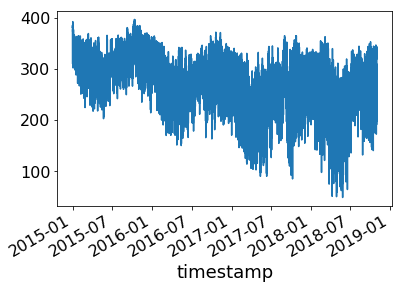

In [4]:
df.carbon_intensity.plot()

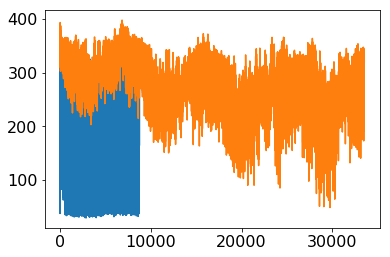

In [5]:
plt.plot(df_carbon.carbon_intensity.values)
plt.plot(df.carbon_intensity.values)

In [6]:
# Split into different years
df16 = df.loc[pd.to_datetime("2016-01-01"):pd.to_datetime("2017-01-01"),:].copy(deep=True)
df18 = df.loc[pd.to_datetime("2017-11-01"):pd.to_datetime("2018-11-01"),:].copy(deep=True)
df25 = df.loc[pd.to_datetime("2016-01-01"):pd.to_datetime("2017-01-01"),:].copy(deep=True)
df25["carbon_intensity"] = df_carbon["carbon_intensity"]

In [7]:
# sanity
df.index.duplicated().sum()

0

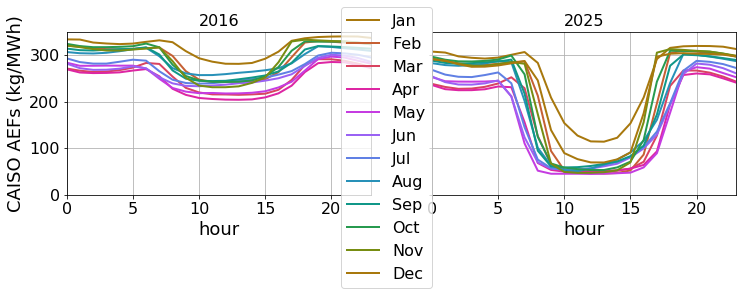

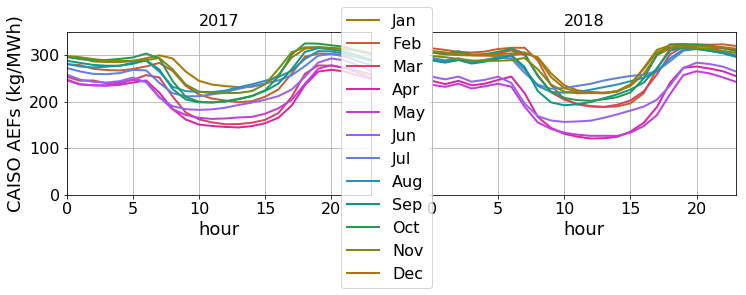

In [8]:
grp_15 = df.loc[pd.to_datetime("2015-01-01"):pd.to_datetime("2015-12-01"),
                ["carbon_intensity", "month", "hour"]].groupby(["month", "hour"]).mean()
grp_16 = df.loc[pd.to_datetime("2016-01-01"):pd.to_datetime("2016-12-01"),
                ["carbon_intensity", "month", "hour"]].groupby(["month", "hour"]).mean()
grp_17 = df.loc[pd.to_datetime("2017-01-01"):pd.to_datetime("2017-12-01"),
                ["carbon_intensity", "month", "hour"]].groupby(["month", "hour"]).mean()
grp_18 = df.loc[pd.to_datetime("2017-11-01"):pd.to_datetime("2018-11-01"),
                ["carbon_intensity", "month", "hour"]].groupby(["month", "hour"]).mean()
grp_25 = df_carbon.loc[:,["carbon_intensity", "month", "hour"]].groupby(["month", "hour"]).mean()

x = np.linspace(0.0, 1.0, len(df.month.unique()))
cm_colors = cmap(x)[np.newaxis, :, :3][0]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3), sharey=True)

for m in df.month.unique():
    ax1.plot(grp_16.loc[m, "carbon_intensity"], label='_nolegend_', color=cm_colors[m-1], lw=2)
    ax2.plot(grp_25.loc[m, "carbon_intensity"], label=calendar.month_abbr[m], color=cm_colors[m-1], lw=2)

ax2.legend(bbox_to_anchor=(0.026, 1.2))

ax1.set_xlim([0,23])
ax2.set_xlim([0,23])
ax1.set_ylim([0,350])
ax1.grid(True)
ax2.grid(True)

ax1.set_xlabel('hour')
ax2.set_xlabel('hour')
ax1.set_ylabel('CAISO AEFs (kg/MWh)')

ax1.set_title("2016")
ax2.set_title("2025")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3), sharey=True)
for m in df.month.unique():
    ax1.plot(grp_17.loc[m, "carbon_intensity"], label='_nolegend_', color=cm_colors[m-1], lw=2)
for m in grp_18.index.get_level_values(level=0).unique():
    ax2.plot(grp_18.loc[m, "carbon_intensity"], label=calendar.month_abbr[m], color=cm_colors[m-1], lw=2)

ax2.legend(bbox_to_anchor=(0.026, 1.2))

ax1.set_xlim([0,23])
ax2.set_xlim([0,23])
ax1.set_ylim([0,350])

ax1.set_xlabel('hour')
ax2.set_xlabel('hour')
ax1.set_ylabel('CAISO AEFs (kg/MWh)')

ax1.set_title("2017")
ax2.set_title("2018")
ax1.grid(True)
ax2.grid(True)

# April carbon intensity of each year, all on the same plot

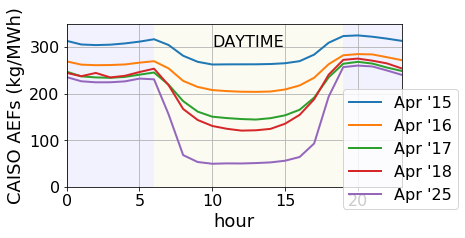

In [9]:
f, ax = plt.subplots(1, 1, figsize=(6,3))
ax.axvspan(0, 6, facecolor='b', alpha=0.05)
ax.axvspan(19, 23, facecolor='b', alpha=0.05)
ax.axvspan(6, 19, facecolor='y', alpha=0.05)
ax.text(10,300, "DAYTIME")

for igrp, grp in zip(['15','16', '17', '18', "25"],[grp_15,grp_16, grp_17, grp_18, grp_25]):
    ax.plot(grp.loc[4, "carbon_intensity"], label="Apr '"+igrp, lw=2)
ax.grid(True)
ax.legend(bbox_to_anchor=(0.8, 0.65))
ax.set_xlim([0,23])
ax.set_ylim([0,350])
ax.set_xlabel('hour')
ax.set_ylabel('CAISO AEFs (kg/MWh)');

# Monthly of each year, all on the same plot

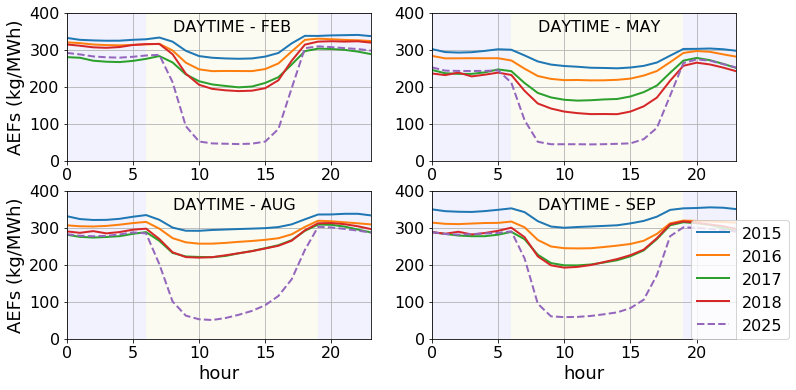

In [10]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,6))
for ax in [ax1, ax2, ax3, ax4]:
    ax.axvspan(0, 6, facecolor='b', alpha=0.05)
    ax.axvspan(19, 23, facecolor='b', alpha=0.05)
    ax.axvspan(6, 19, facecolor='y', alpha=0.05)

for m, ax in zip([2,5,8,9], [ax1, ax2, ax3, ax4]):
    for igrp, grp in zip([2015,2016,2017,2018,2025],[grp_15,grp_16, grp_17, grp_18, grp_25]):
        ls="-"
        if igrp == 2025:
            ls = "--"
        ax.plot(grp.loc[m, "carbon_intensity"], label=igrp, lw=2, ls=ls)
    ax.text(8,350, "DAYTIME - %s" % calendar.month_abbr[m].upper())


for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([0,23])
    ax.set_ylim([0,400])
    ax.grid(True)
ax1.set_ylabel('AEFs (kg/MWh)');
ax3.set_ylabel('AEFs (kg/MWh)');
ax3.set_xlabel('hour')
ax4.set_xlabel('hour')
ax4.legend(loc=7, bbox_to_anchor=(1.2, 0.4))


# Yearly carbon intensity of each year, all on the same plot

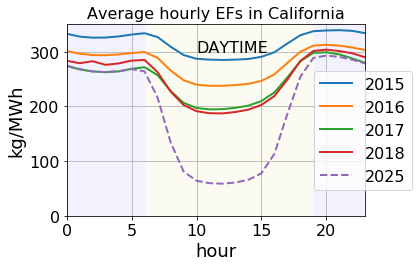

In [11]:
grp_15 = df.loc[pd.to_datetime("2015-01-01"):pd.to_datetime("2015-12-01"),
                ["carbon_intensity", "year", "hour"]].groupby(["year", "hour"]).mean()
grp_16 = df.loc[pd.to_datetime("2016-01-01"):pd.to_datetime("2016-12-01"),
                ["carbon_intensity", "year", "hour"]].groupby(["year", "hour"]).mean()
grp_17 = df.loc[pd.to_datetime("2017-01-01"):pd.to_datetime("2017-12-01"),
                ["carbon_intensity", "year", "hour"]].groupby(["year", "hour"]).mean()
grp_18 = df.loc[pd.to_datetime("2018-01-01"):pd.to_datetime("2018-12-01"),
                ["carbon_intensity", "year", "hour"]].groupby(["year", "hour"]).mean()
grp_25 = df_carbon.loc[:,["carbon_intensity", "year", "hour"]].groupby(["year", "hour"]).mean()

# April of each year, all on the same plot
#f, ax = plt.subplots(1, 1, figsize=(6,4))
f, ax = plt.subplots(1, 1)
ax.axvspan(0, 6, facecolor='b', alpha=0.05)
ax.axvspan(19, 23, facecolor='b', alpha=0.05)
ax.axvspan(6, 19, facecolor='y', alpha=0.05)
ax.text(10,300, "DAYTIME")



for igrp, grp in zip([2015,2016, 2017, 2018, 2025],[grp_15,grp_16, grp_17, grp_18, grp_25]):
    ls="-"
    sel = igrp
    if igrp == 2025:
        ls = "--"
        sel = 2016
    ax.plot(grp.loc[sel, "carbon_intensity"], label=igrp, lw=2, ls=ls)
ax.grid(True)
ax.legend(loc=2, bbox_to_anchor=(0.8, 0.8))
ax.set_xlim([0,23])
ax.set_ylim([0,350])
ax.set_xlabel('hour')
ax.set_title('Average hourly EFs in California');
ax.set_ylabel('kg/MWh');
plt.tight_layout()
plt.savefig('aefs.pdf')
plt.savefig('aefs.png')

In [12]:
# Hourly Emissions analysis (in ktonnes)

# Calculate references
footprint_h_16 = df16.carbon_intensity.sum() * 1e-6
footprint_y_16 = df16.carbon_intensity.mean() * len(df16.solarpv) * 1e-6

# Choose scenario
def calcs(df, verb=0):
    df.loc[:,"wind_100"] = df.loc[:, "wind"] * len(df) / df.wind.sum()
    df.loc[:,"wind_50"] = 0.5 * df.loc[:, "wind"] * len(df) / df.wind.sum()
    df.loc[:,"solarpv_100"] = df.loc[:, "solarpv"] * len(df) / df.solarpv.sum()
    df.loc[:,"solarpv_50"] = 0.5 * df.loc[:, "solarpv"] * len(df) / df.solarpv.sum()
    
    # Hourly calcs
    footprint_h = df.carbon_intensity.sum() * 1e-6
    df.loc[:,"avoided100_s_h"] = df.solarpv_100*(df.carbon_intensity-CARBON_INTENSITY['solarpv'])
    df.loc[:,"avoided100_w_h"] = df.wind_100*(df.carbon_intensity-CARBON_INTENSITY['wind'])
    df.loc[:,"avoided5050_h"] = (df.solarpv_50*(df.carbon_intensity-CARBON_INTENSITY['solarpv'])
                                 + df.wind_50*(df.carbon_intensity-CARBON_INTENSITY['wind']))
    avoided100_s_h = np.nansum(df.avoided100_s_h) * 1e-6
    avoided100_w_h = np.nansum(df.avoided100_w_h) * 1e-6
    avoided5050_h = np.nansum(df.avoided5050_h) * 1e-6
    footprint_100_s_h = footprint_h-avoided100_s_h
    footprint_100_w_h = footprint_h-avoided100_w_h
    footprint_5050_h = footprint_h-avoided5050_h
    
    if verb > 0:
        print("Hourly")
        print("Emissions footprint: %g" % footprint_h)
        print("Avoided tons 100 %% solar: %g" % avoided100_s_h)
        print("Avoided tons 100 %% wind: %g" % avoided100_w_h)
        print("Avoided tons 50 %% wind, 50 %% solar: %g" % avoided5050_h)

    # Yearly calcs
    GRID_AVG_CARBON = df.carbon_intensity.mean()
    footprint_y = GRID_AVG_CARBON * len(df.carbon_intensity) * 1e-6
    df.loc[:,"avoided100_s_y"] = df.solarpv_100 * (GRID_AVG_CARBON-CARBON_INTENSITY['solarpv'])
    df.loc[:,"avoided100_w_y"] = df.wind_100 * (GRID_AVG_CARBON-CARBON_INTENSITY['wind'])
    df.loc[:,"avoided5050_y"] = (df.solarpv_50 * (GRID_AVG_CARBON-CARBON_INTENSITY['solarpv'])
                                 + df.wind_50 * (GRID_AVG_CARBON-CARBON_INTENSITY['wind']))
    avoided100_s_y =  np.nansum(df.avoided100_s_y) * 1e-6
    avoided100_w_y = np.nansum(df.avoided100_w_y) * 1e-6
    avoided5050_y = np.nansum(df.avoided5050_y) * 1e-6
    footprint_100_s_y = footprint_y-avoided100_s_y
    footprint_100_w_y = footprint_y-avoided100_w_y
    footprint_5050_y = footprint_y-avoided5050_y
    
    if verb > 0:
        print("\nYearly")
        print("Emissions footprint: %g" % footprint_y)
        print("Avoided tons 100 %% solar: %g" % avoided100_s_y)
        print("Avoided tons 100 %% wind: %g" % avoided100_w_y)
        print("Avoided tons 50 %% wind, 50 %% solar: %g" % avoided5050_y)

    # Summary dataframe to hold the results
    df_sum = pd.DataFrame(
        index=["Grid", "solar100", "wind100", "sw5050"],
        columns=["indirect_CO2_H", "avoided_CO2_H", "indirect_red_H",
                 "indirect_CO2_Y", "avoided_CO2_Y", "indirect_red_Y"])

    df_sum.loc["Grid",:] = [footprint_h, 0., (footprint_h_16-footprint_h)/footprint_h_16,
                            footprint_y, 0.,(footprint_y_16-footprint_y)/footprint_y_16]
    df_sum.loc["solar100",:] = [footprint_100_s_h, avoided100_s_h, (footprint_h_16-footprint_100_s_h)/footprint_h_16,
                            footprint_100_s_y, avoided100_s_y,(footprint_y_16-footprint_100_s_y)/footprint_y_16]
    df_sum.loc["wind100",:] = [footprint_100_w_h, avoided100_w_h, (footprint_h_16-footprint_100_w_h)/footprint_h_16,
                            footprint_100_w_y, avoided100_w_y, (footprint_y_16-footprint_100_w_y)/footprint_y_16]
    df_sum.loc["sw5050",:] = [footprint_5050_h, avoided5050_h, (footprint_h_16-footprint_5050_h)/footprint_h_16,
                            footprint_5050_y, avoided5050_y, (footprint_y_16-footprint_5050_y)/footprint_y_16]
    return df_sum

df_sum16 = calcs(df16)
df_sum18 = calcs(df18)
df_sum25 = calcs(df25)

In [13]:
df_sum16

indirect_CO2_H avoided_CO2_H indirect_red_H indirect_CO2_Y  \
Grid            2.45907             0              0        2.45907   
solar100       0.729184       1.72989       0.703472        0.40296   
wind100        0.203296       2.25578       0.917328        0.10512   
sw5050          0.46624       1.99283         0.8104        0.25404   

         avoided_CO2_Y indirect_red_Y  
Grid                 0              0  
solar100       2.05611       0.836133  
wind100        2.35395       0.957252  
sw5050         2.20503       0.896693

In [14]:
df_sum25

indirect_CO2_H avoided_CO2_H indirect_red_H indirect_CO2_Y  \
Grid            1.70623             0       0.306151        1.70623   
solar100        1.46317      0.243059       0.404993        0.40296   
wind100        0.114401       1.59183       0.953478        0.10512   
sw5050         0.788784      0.917443       0.679235        0.25404   

         avoided_CO2_Y indirect_red_Y  
Grid                 0       0.306151  
solar100       1.30327       0.836133  
wind100        1.60111       0.957252  
sw5050         1.45219       0.896693

In [15]:
df_sum18

indirect_CO2_H avoided_CO2_H indirect_red_H indirect_CO2_Y  \
Grid            2.23841             0      0.0897363        2.23841   
solar100       0.882933       1.35547       0.640949       0.400798   
wind100        0.191083       2.04732       0.922295       0.104556   
sw5050         0.537008        1.7014       0.781622       0.252677   

         avoided_CO2_Y indirect_red_Y  
Grid                 0      0.0897363  
solar100       1.83761       0.837013  
wind100        2.13385       0.957482  
sw5050         1.98573       0.897247

# One day of the month

Text(0.5, 0, 'hour')

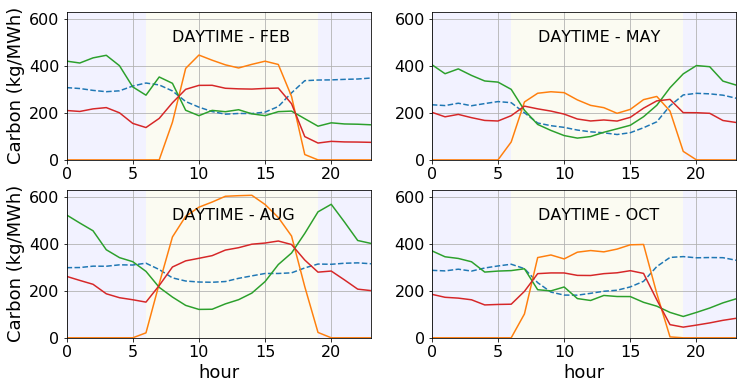

In [16]:
# Pick a day in April and make example plot
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,6))
for ax in [ax1, ax2, ax3, ax4]:
    ax.axvspan(0, 6, facecolor='b', alpha=0.05)
    ax.axvspan(19, 23, facecolor='b', alpha=0.05)
    ax.axvspan(6, 19, facecolor='y', alpha=0.05)
dates = [(pd.to_datetime("2018-02-15"),pd.to_datetime("2018-02-16")),
         (pd.to_datetime("2018-05-15"),pd.to_datetime("2018-05-16")),
        (pd.to_datetime("2018-08-15"),pd.to_datetime("2018-08-16")),
        (pd.to_datetime("2018-10-15"),pd.to_datetime("2018-10-16"))]
for date, ax in zip(dates, [ax1, ax2, ax3, ax4]):
    df_plot = df18.loc[date[0]:date[1], :]
    ax.plot(list(range(25)), df_plot.carbon_intensity.values, '--')
    ax.plot(list(range(25)), df_plot.avoided100_s_h.values)
    ax.plot(list(range(25)), df_plot.avoided100_w_h.values)
    ax.plot(list(range(25)), df_plot.avoided5050_h.values)
    ax.text(8,500, "DAYTIME - %s" % calendar.month_abbr[date[0].month].upper())

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([0,23])
    ax.set_ylim([0,630])
    ax.grid(True)
ax1.set_ylabel('Carbon (kg/MWh)');
ax3.set_ylabel('Carbon (kg/MWh)');
ax3.set_xlabel('hour')
ax4.set_xlabel('hour')

# Average day each month - 2018

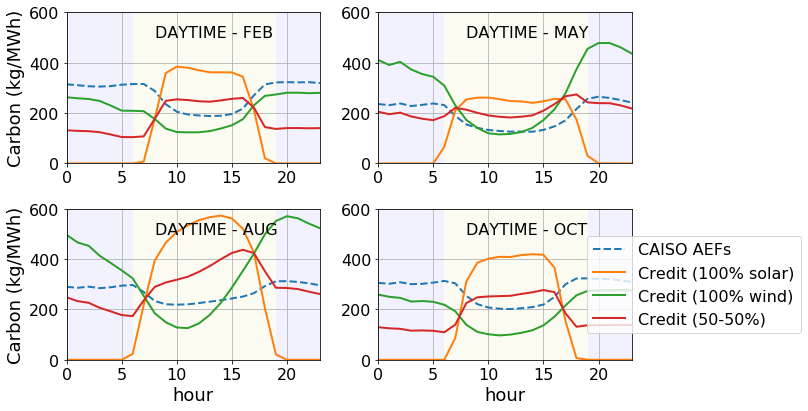

In [23]:
# Use average days in April

df18.month = df18.index.month
df18.hour = df18.index.hour
grped = df18.loc[:,[
        "carbon_intensity","avoided100_s_h", "avoided100_w_h",
        "avoided5050_h", "month", "hour"]].groupby([
        "month", "hour"]).mean()
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,6))
for ax in [ax1, ax2, ax3, ax4]:
    ax.axvspan(0, 6, facecolor='b', alpha=0.05)
    ax.axvspan(19, 23, facecolor='b', alpha=0.05)
    ax.axvspan(6, 19, facecolor='y', alpha=0.05)
    
for m, ax in zip([2, 5, 8, 10],[ax1, ax2, ax3, ax4]):
    ax.plot(grped.loc[m, "carbon_intensity"], lw=2, ls='--', label="CAISO AEFs")
    ax.plot(grped.loc[m, "avoided100_s_h"], lw=2, label="Credit (100% solar)")
    ax.plot(grped.loc[m, "avoided100_w_h"], lw=2, label="Credit (100% wind)")
    ax.plot(grped.loc[m, "avoided5050_h"], lw=2, label="Credit (50-50%)")
    ax.text(8,500, "DAYTIME - %s" % calendar.month_abbr[m].upper())

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([0,23])
    ax.set_ylim([0,600])
    ax.grid(True)
ax1.set_ylabel('Carbon (kg/MWh)');
ax3.set_ylabel('Carbon (kg/MWh)');
ax3.set_xlabel('hour')
ax4.set_xlabel('hour')
ax4.legend(loc=7, bbox_to_anchor=(1.7, 0.5))

plt.tight_layout()
plt.savefig('fig2a.pdf')
plt.savefig('fig2a.png')


# Average day each month - 2025

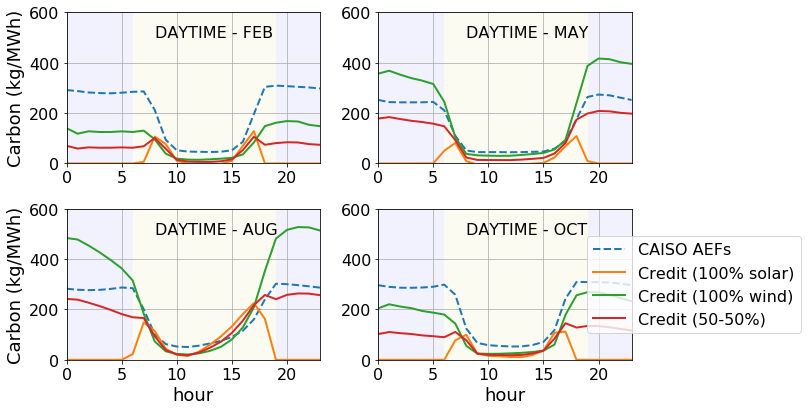

In [24]:
df25.month = df25.index.month
df25.hour = df25.index.hour
grped = df25.loc[:,[
        "carbon_intensity","avoided100_s_h", "avoided100_w_h",
        "avoided5050_h", "month", "hour"]].groupby([
        "month", "hour"]).mean()
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,6))
for ax in [ax1, ax2, ax3, ax4]:
    ax.axvspan(0, 6, facecolor='b', alpha=0.05)
    ax.axvspan(19, 23, facecolor='b', alpha=0.05)
    ax.axvspan(6, 19, facecolor='y', alpha=0.05)

for m, ax in zip([2, 5, 8, 10],[ax1, ax2, ax3, ax4]):
    ax.plot(grped.loc[m, "carbon_intensity"], lw=2, ls='--', label="CAISO AEFs")
    ax.plot(grped.loc[m, "avoided100_s_h"], lw=2, label="Credit (100% solar)")
    ax.plot(grped.loc[m, "avoided100_w_h"], lw=2, label="Credit (100% wind)")
    ax.plot(grped.loc[m, "avoided5050_h"], lw=2, label="Credit (50-50%)")
    ax.text(8,500, "DAYTIME - %s" % calendar.month_abbr[m].upper())

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([0,23])
    ax.set_ylim([0,600])
    ax.grid(True)
ax1.set_ylabel('Carbon (kg/MWh)');
ax3.set_ylabel('Carbon (kg/MWh)');
ax3.set_xlabel('hour')
ax4.set_xlabel('hour')
ax4.legend(loc=7, bbox_to_anchor=(1.7, 0.5))

plt.tight_layout()
plt.savefig('fig2b.pdf')
plt.savefig('fig2b.png')


# Reprint grid mixes

In [37]:
for col in ['biogas', 'biomass', 'geo', 'hydro', 'nuclear',
            'smhydro','solarpv', 'solarth','thermal','wind',
            'imports']:
    print("%s: %.2f\t%.2f\t%.2f"%tuple([col.ljust(10, " ")]+[100*mydf[col].sum()/mydf.total.sum() for mydf in [df16, df18, df25]]))
        

biogas    : 0.67	0.89	0.67
biomass   : 0.84	1.28	0.84
geo       : 3.72	3.63	3.72
hydro     : 9.77	9.85	9.77
nuclear   : 8.19	8.15	8.19
smhydro   : 1.25	1.46	1.25
solarpv   : 8.43	11.68	8.43
solarth   : 0.55	0.52	0.55
thermal   : 32.66	27.87	32.66
wind      : 5.99	7.11	5.99
imports   : 27.93	27.56	27.93


In [44]:
df16.columns

Index(['biogas', 'biomass', 'geo', 'hydro', 'imports', 'nuclear', 'smhydro',
       'solarpv', 'solarth', 'thermal', 'wind', 'carbon', 'total',
       'carbon_intensity', 'year', 'month', 'hour', 'wind_100', 'wind_50',
       'solarpv_100', 'solarpv_50', 'avoided100_s_h', 'avoided100_w_h',
       'avoided5050_h', 'avoided100_s_y', 'avoided100_w_y', 'avoided5050_y'],
      dtype='object')

In [47]:
cols = ['biogas', 'biomass', 'geo', 'hydro', 'imports', 'nuclear', 'smhydro',
       'solarpv', 'solarth', 'thermal', 'wind']

# generate scenarios
frames=dict()
for x in [0,2]:
    print("\n\n\n",x)
    print("max overgen power on grid (GW)")
    print(min(df16.total - (1+x) * df16.solarpv)/1e3)

    df_solar = df16.copy()

    # reduce thermal, but don't go negative
    df_solar.thermal = df_solar.apply(
        lambda row : max(row.thermal - x*row.solarpv, 0), axis=1)

    # take all the solar
    df_solar.solarpv = df_solar.apply(
        lambda row : (1 + x) * row.solarpv, axis=1)

    overgenP = df_solar.total - df_solar[cols].sum(axis=1)
    overgen = overgenP.sum()
    print("overgen energy %")
    print(100 * overgen/df_solar.total.sum())
    print(overgen)
    # reduce imports if needed
    if overgen<-1*1e5:
        print("Reducing imports as well")
        df_solar.imports = (df_solar.imports + overgenP)
        df_solar.imports = df_solar.apply(
            lambda row: max(row.imports, 0), axis=1)
        overgen = (df_solar.total - df_solar[cols].sum(axis=1)).sum()


    # reshape the gas/imports homogeneously to accomodate
    print("overgen energy %")
    print(100 * overgen/df_solar.total.sum())
    print(overgen)
    it=0
    while (overgen<-1*1e3) & (it<10): # GWh
        it+=1
        if it%2==0:
            df_solar.thermal = df_solar.thermal.apply(
                lambda x:max(x+overgen/len(df_solar),0))
        else:
            df_solar.imports = df_solar.imports.apply(
                lambda x:max(x+overgen/len(df_solar),0))
        overgen = (df_solar.total - df_solar[cols].sum(axis=1)).sum()
        if sum(df_solar.thermal)<1e3 and sum(df_solar.imports)<1e-3:
            print("Too much solar!")

    print("there is %.2f overgen after %d iterations"%(overgen,it))

    # recalculate carbon intensity and total carbon of the grid
    df_solar["carbon"] = df_solar.apply(
        lambda row:sum(row[fuel]*CARBON_INTENSITY[fuel]
                       for fuel in CARBON_INTENSITY)/1e3, axis=1)
    df_solar["carbon_intensity"] = df_solar.apply(
        lambda row:row["carbon"]*1e3/row["total"], axis=1)

    # print summary stats
    print("old total gen (TWh)")
    print(df16.total.sum()/1e6)
    print("new total gen (TWh)")
    print(df_solar.total.sum()/1e6)
    print("new total gen (TWh) - sanity")
    print(df_solar[cols].sum(axis=1).sum()/1e6)
    print("solar energy %")
    print(100*df_solar.solarpv.sum()/df_solar.total.sum())
    print("gas energy %")
    print(100*df_solar.thermal.sum()/df_solar.total.sum())
    print("imports %")
    print(100*df_solar.imports.sum()/df_solar.total.sum())
    #print("max solar GW (old)")
    #print(max(df_watttime.fuel_solar)/1e3)
    print("max solar (GW)")
    print(max(df_solar.solarpv)/1e3)
    print("Solar Gen (TWh)")
    print(df_solar.solarpv.sum()/1e6)
    print("CO2 emissions (Mtonnes)")
    print(df_solar.carbon.sum()/1e6)
    print("Yearly CO2 emissions reduction (%)")
    print(100*(1-df_solar.carbon.sum()/df16.carbon.sum()))
    
    frames[x] = df_solar




 0
max overgen power on grid (GW)
14.333
overgen energy %
0.0
0.0
overgen energy %
0.0
0.0
there is 0.00 overgen after 0 iterations
old total gen (TWh)
230.551195
new total gen (TWh)
230.551195
new total gen (TWh) - sanity
230.551195
solar energy %
8.434178361122786
gas energy %
32.664507768003546
imports %
27.92846898928457
max solar (GW)
7.857
Solar Gen (TWh)
19.445099
CO2 emissions (Mtonnes)
64.79267547100001
Yearly CO2 emissions reduction (%)
0.0



 2
max overgen power on grid (GW)
0.52
overgen energy %
-5.450686993836662
-12566624.0
Reducing imports as well
overgen energy %
-0.8392344268699193
-1934865.0
there is -198.22 overgen after 5 iterations
old total gen (TWh)
230.551195
new total gen (TWh)
230.551195
new total gen (TWh) - sanity
230.55139322161014
solar energy %
25.302535083368358
gas energy %
21.1816728851442
imports %
22.543033127162598
max solar (GW)
23.571
Solar Gen (TWh)
58.335297
CO2 emissions (Mtonnes)
48.85127833911448
Yearly CO2 emissions reduction (%)
24.6037

In [52]:
for col in ['biogas', 'biomass', 'geo', 'hydro', 'nuclear',
            'smhydro','solarpv', 'solarth','thermal','wind',
            'imports']:
    print("%s: %.2f"%tuple([col.ljust(10, " ")]+[100*frames[2][col].sum()/frames[2].total.sum()]))
        

biogas    : 0.67
biomass   : 0.84
geo       : 3.72
hydro     : 9.77
nuclear   : 8.19
smhydro   : 1.25
solarpv   : 25.30
solarth   : 0.55
thermal   : 21.18
wind      : 5.99
imports   : 22.54
